<a href="https://colab.research.google.com/github/prithishsamanta/Electrical-Load-Balancer-Using-LSTMs-and-GRUs/blob/main/Final_Capstone_GRU_Test_RTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

In [ ]:
# df = pd.read_csv('/content/ercot-dataset.csv')
# df.head()

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = 'drive/My Drive/Capstone'

In [ ]:
df = pd.read_csv(path+'/capstone_dataset_rte.csv')
df.head(10)

,Date,Day,Month,Year,Hours,Temperature,Demand,Forcast J-1,Forcast J
0,01-01-13,1,1,2013,0,6.800,61194,60300,60200
1,01-01-13,1,1,2013,1800,6.710,59674,59500,58700
2,01-01-13,1,1,2013,3600,6.620,57877,57500,56700
3,01-01-13,1,1,2013,5400,6.530,57755,57800,57400
4,01-01-13,1,1,2013,7200,6.440,57243,57600,57200
5,01-01-13,1,1,2013,9000,6.390,56660,56400,55600
6,01-01-13,1,1,2013,10800,6.340,54376,54900,53400
7,01-01-13,1,1,2013,12600,6.305,52640,53200,51600
8,01-01-13,1,1,2013,14400,6.270,50796,51800,49900
9,01-01-13,1,1,2013,16200,6.270,49860,50700,48900


In [ ]:
features_considered = ['Demand', 'Temperature', 'Forcast J-1', 'Forcast J']

In [ ]:
features = df[features_considered]
features.index = df['Date']
features.head()

,Demand,Temperature,Forcast J-1,Forcast J
Date,,,,
01-01-13,61194,6.80,60300,60200
01-01-13,59674,6.71,59500,58700
01-01-13,57877,6.62,57500,56700
01-01-13,57755,6.53,57800,57400
01-01-13,57243,6.44,57600,57200


In [ ]:
values = features.values
values = values.astype('float32')

In [ ]:
print(values)

[[6.1194e+04 6.8000e+00 6.0300e+04 6.0200e+04]
 [5.9674e+04 6.7100e+00 5.9500e+04 5.8700e+04]
 [5.7877e+04 6.6200e+00 5.7500e+04 5.6700e+04]
 ...
 [7.1924e+04 1.2150e+00 7.0800e+04 7.2300e+04]
 [7.5424e+04 1.1400e+00 7.4200e+04 7.5600e+04]
 [7.5504e+04 1.1000e+00 7.4600e+04 7.6600e+04]]


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)

In [ ]:
scaled.head(4)

,0,1,2,3
0,0.502233,0.283751,0.492260,0.645923
1,0.478164,0.281326,0.479876,0.629828
2,0.449709,0.278901,0.448916,0.608369
3,0.447777,0.276475,0.453560,0.615880


In [ ]:
def create_ts_data(dataset, lookback=1, predicted_col=1):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]  # copies all the values to the temp variable
    temp.set_index('id', inplace =True)  # makes id the index column of the dataset
    predicted_value=dataset.copy()  # cpoies all the values to the new variable
    predicted_value = predicted_value.iloc[lookback:,predicted_col]  # sets the 0th coulmn as the column to be predicted
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)

    predicted_value["id"]= range(1, len(predicted_value)+1)  # adding the id column to the predicted value
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)  # concats the 2 variables to 1, the new variable has 7 columns
    #  final_df has (t-1) time data in the first 6 columns, which is used to predict the load at time (t), present in the 7th column

    return final_df

In [ ]:
reframed_df= create_ts_data(scaled, 1,0)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var1(t)']
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
id                                                      
1    0.502233   0.283751   0.492260   0.645923  0.478164
2    0.478164   0.281326   0.479876   0.629828  0.449709
3    0.449709   0.278901   0.448916   0.608369  0.447777
4    0.447777   0.276475   0.453560   0.615880  0.439669


In [ ]:
values = reframed_df.values
training_sample = int( len(df) *0.8)
val_sample = int( len(df) * 0.1) + training_sample
train = values[:training_sample, :]
val = values[training_sample:val_sample, :]
test = values[val_sample:, :]

# split into input and outputs

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]

In [ ]:
print("train_X:", train_X, "\n\ntrain_y:", train_y, "\n\nval_X:", val_X, "\n\nval_y:", val_y, "\n\ntest_X:", test_X, "\n\ntest_y:", test_y)

train_X: [[0.5022328  0.283751   0.49226004 0.6459227 ]
 [0.4781638  0.2813258  0.47987616 0.62982833]
 [0.44970867 0.27890056 0.44891644 0.6083691 ]
 ...
 [0.5118761  0.36890325 0.49535602 0.6491416 ]
 [0.5259533  0.3562382  0.5123839  0.6609442 ]
 [0.55907965 0.34276474 0.54798764 0.68454933]] 

train_y: [0.4781638  0.44970867 0.44777682 ... 0.5259533  0.55907965 0.6247467 ] 

val_X: [[0.6247467  0.32929128 0.622291   0.7360515 ]
 [0.6747371  0.31676096 0.66408664 0.76502144]
 [0.6605016  0.30423066 0.6470588  0.7532189 ]
 ...
 [0.15112743 0.71355426 0.16718268 0.42274678]
 [0.15559289 0.6914578  0.17027867 0.42381975]
 [0.15030405 0.6716518  0.16563469 0.4216738 ]] 

val_y: [0.6747371  0.6605016  0.6244141  ... 0.15559289 0.15030405 0.14746961] 

test_X: [[0.14746961 0.6518458  0.16099072 0.42060086]
 [0.1651729  0.6378334  0.17647058 0.43240345]
 [0.18094441 0.623821   0.18421054 0.4388412 ]
 ...
 [0.6542311  0.13527352 0.622291   0.7553648 ]
 [0.67214024 0.13325249 0.6547988  0.77

In [ ]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(56102, 1, 4) (56102,) (7012, 1, 4) (7012,) (7013, 1, 4) (7013,)


In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.2))

model_lstm.add(LSTM(units=30, return_sequences=True))
# model.add(Dropout(0.2))

model_lstm.add(LSTM(units=30))
# model.add(Dropout(0.2))

model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 75)             24000     
                                                                 
 lstm_1 (LSTM)               (None, 1, 30)             12720     
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 44,071
Trainable params: 44,071
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_lstm = model_lstm.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(val_X, val_y),  shuffle=False)

Epoch 1/10
877/877 [==============================] - 9s 5ms/step - loss: 0.0562 - val_loss: 0.0344
Epoch 2/10
877/877 [==============================] - 4s 4ms/step - loss: 0.0191 - val_loss: 0.0173
Epoch 3/10
877/877 [==============================] - 5s 5ms/step - loss: 0.0184 - val_loss: 0.0155
Epoch 4/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0183 - val_loss: 0.0153
Epoch 5/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0182 - val_loss: 0.0150
Epoch 6/10
877/877 [==============================] - 5s 5ms/step - loss: 0.0180 - val_loss: 0.0153
Epoch 7/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0179 - val_loss: 0.0151
Epoch 8/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0177 - val_loss: 0.0153
Epoch 9/10
877/877 [==============================] - 5s 5ms/step - loss: 0.0175 - val_loss: 0.0160
Epoch 10/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0174 - val_loss: 0.0173

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')

In [ ]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 75)             18225     
                                                                 
 gru_1 (GRU)                 (None, 1, 30)             9630      
                                                                 
 gru_2 (GRU)                 (None, 30)                5580      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 33,466
Trainable params: 33,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gru_history = model_gru.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(val_X, val_y), shuffle=False)

Epoch 1/10
877/877 [==============================] - 10s 6ms/step - loss: 0.0347 - val_loss: 0.0187
Epoch 2/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 3/10
877/877 [==============================] - 5s 5ms/step - loss: 0.0178 - val_loss: 0.0192
Epoch 4/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0177 - val_loss: 0.0187
Epoch 5/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0175 - val_loss: 0.0195
Epoch 6/10
877/877 [==============================] - 5s 5ms/step - loss: 0.0174 - val_loss: 0.0204
Epoch 7/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0174 - val_loss: 0.0207
Epoch 8/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0173 - val_loss: 0.0204
Epoch 9/10
877/877 [==============================] - 5s 5ms/step - loss: 0.0172 - val_loss: 0.0226
Epoch 10/10
877/877 [==============================] - 4s 5ms/step - loss: 0.0172 - val_loss: 0.023

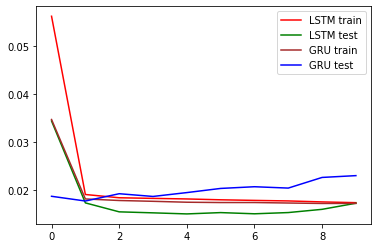

In [ ]:
pyplot.plot(history_lstm.history['loss'], label='LSTM train', color='red')
pyplot.plot(history_lstm.history['val_loss'], label='LSTM VAL', color= 'green')
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU VAL', color='blue')
pyplot.legend()
pyplot.show()

In [ ]:
predicted_lstm = model_lstm.predict(test_X)
actual_lstm = test_y

220/220 [==============================] - 1s 2ms/step


In [ ]:
print(predicted_lstm)
print(actual_lstm)

[[0.16720445]
 [0.18261926]
 [0.19389561]
 ...
 [0.6530577 ]
 [0.67681015]
 [0.7291084 ]]
[0.1651729  0.18094441 0.19196543 ... 0.67214024 0.72756207 0.7288289 ]


In [ ]:
predicted_gru = model_gru.predict(test_X)
actual_gru = test_y

220/220 [==============================] - 1s 2ms/step


In [ ]:
print(predicted_gru)
print(actual_gru)

[[0.18377024]
 [0.19848236]
 [0.20971066]
 ...
 [0.661063  ]
 [0.683964  ]
 [0.7378222 ]]
[0.1651729  0.18094441 0.19196543 ... 0.67214024 0.72756207 0.7288289 ]


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn.metrics import mean_absolute_error
from math import sqrt

mape_lstm = sqrt(mean_absolute_percentage_error(predicted_lstm, actual_lstm))
mse_lstm = mean_absolute_error(actual_lstm, predicted_lstm)

mape_gru = sqrt(mean_absolute_percentage_error(predicted_gru, actual_gru))
mse_gru = mean_absolute_error(actual_gru, predicted_gru)

In [ ]:
print("mape_model_lstm: ", mape_lstm)
print("mse_model_lstm: ", mse_lstm)
print("mape_model_gru: ", mape_gru)
print("mse_model_gru: ", mse_gru)

mape_model_lstm:  8.219845035257096
mse_model_lstm:  0.019457404
mape_model_gru:  7.872086455263888
mse_model_gru:  0.023852682


In [ ]:
predicted_gru[1:5]

array([[0.19848236],
       [0.20971066],
       [0.22222522],
       [0.2576451 ]], dtype=float32)

In [ ]:
actual_gru[:4]

array([0.1651729 , 0.18094441, 0.19196543, 0.23180583], dtype=float32)

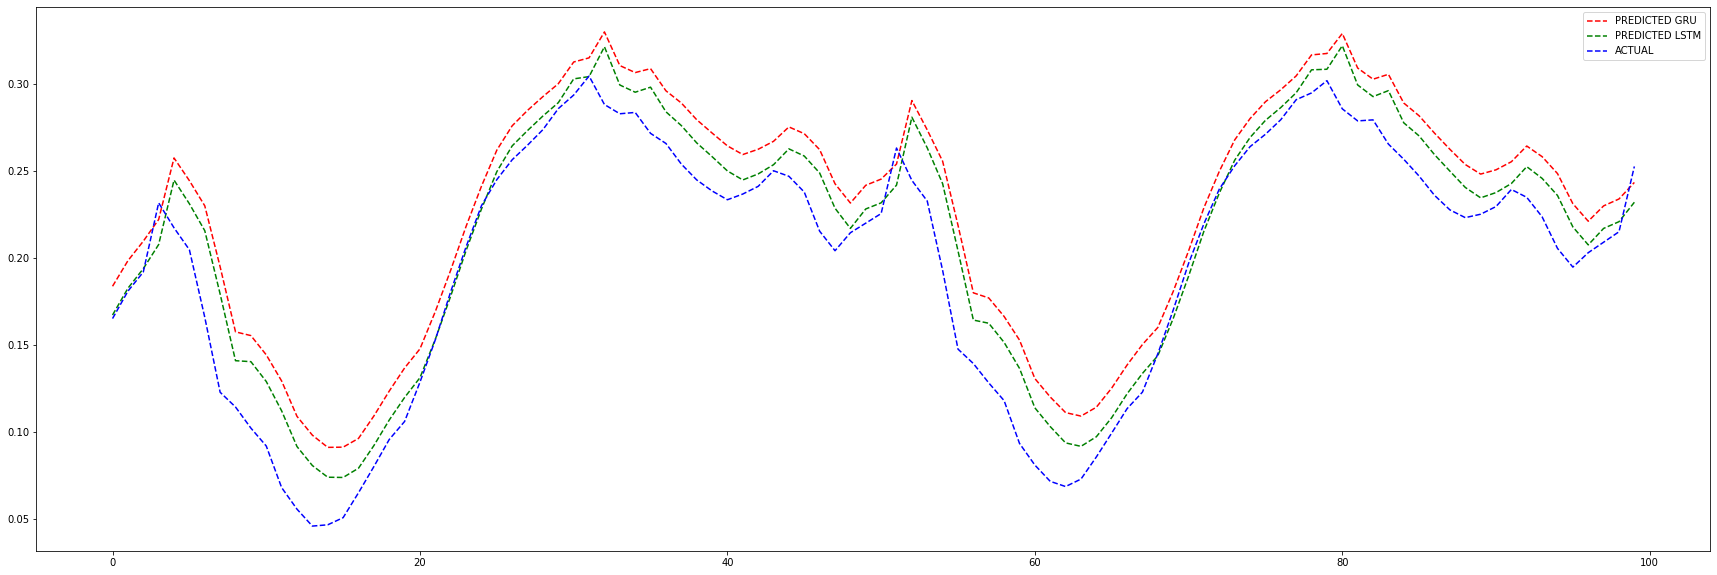

In [ ]:
pyplot.figure(figsize=(30,10))
pyplot.plot(predicted_gru[:100],'r--',label="PREDICTED GRU")
pyplot.plot(predicted_lstm[:100],'g--',label="PREDICTED LSTM")
pyplot.plot(actual_gru[:100],'b--',label="ACTUAL")
pyplot.legend()
pyplot.show()